In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn import preprocessing, cluster, metrics

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()

powderthickness = 80
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
ims = np.array([np.array(plt.imread(path)) for path in paths_sorted])

paths = pathlib.Path('./OT data 80 um/max').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
maxs = np.array([np.array(plt.imread(path)) for path in paths_sorted])
# Don't touch original
original = np.copy(ims)
integrals = original

unique, counts = np.unique(ims, return_counts=True)

In [2]:
objectwidth = 83
objectheight = 122
xspacing = 134
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])


We have a dataset of OT images from an AM process. The dataset consists of images of the integral of each layer, as well as the maximum value. Each image is 2000x2000 pixels. Each layer is 80um. The objects are numbered from 1 (bottom left) to 28 (top right). The volumetric energy density and porosity for each object is:

   Object        VED  Porosity
0      H1  46.875000     0.037
1      H2  21.634615     4.847
2      H3  34.090909     0.071
3      H4  38.194444     0.046
4      H5  34.090909     0.092
5      H6  39.663462     0.049
6      H7  31.250000     0.051
7      H8  26.442308     1.002
8      H9  34.090909     0.067
9     H10  32.451923     0.071
10    H11  57.291667     0.044
11    H12  34.090909     0.105
12    H13  34.090909     0.033
13    H14  26.785714     0.641
14    H15  50.655140     0.100
15    H16  25.690210     0.844
16    H17  39.659091     0.045
17    H18  34.090909     0.024
18    H19  28.522727     0.286
19    H20  46.875000     0.055
20    H21  58.829066     0.273
21    H22  16.707656    19.137
22    H23  33.616609     0.088
23    H24  29.238398     0.085
24    H25  23.390719     2.480
25    H26  47.063253     0.046
26    H27  40.933757     0.036
27    H28  82.360693     0.456


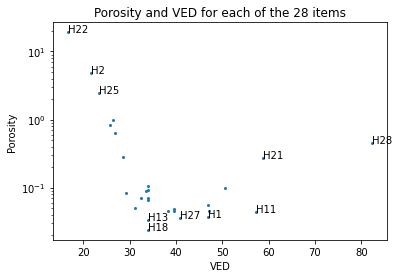

In [3]:
print(objectinfo.filter(items=['Object', "VED", "Porosity"]))
plt.scatter(objectinfo.filter(items=['VED']), objectinfo.filter(items=['Porosity']), s=4)
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("VED")
plt.title("Porosity and VED for each of the 28 items")
for index, row in objectinfo.iloc[[0, 1, 10, 12, 17, 20, 21, 24, 26, 27]].iterrows():
    plt.annotate(text=row.Object, xy=(row.VED, row.Porosity))

Let's look at one of the images

(array([2.537607e+06, 4.298560e+05, 2.941320e+05, 1.632540e+05,
        8.684000e+04, 3.820300e+04, 1.663300e+04, 1.000900e+04,
        8.683000e+03, 9.338000e+03, 1.239800e+04, 1.603800e+04,
        1.897500e+04, 2.005100e+04, 1.970100e+04, 1.654700e+04,
        1.620200e+04, 1.867400e+04, 2.411800e+04, 2.813400e+04,
        2.822400e+04, 2.517300e+04, 2.086800e+04, 1.626400e+04,
        1.260300e+04, 9.980000e+03, 7.798000e+03, 6.288000e+03,
        5.558000e+03, 4.730000e+03, 4.098000e+03, 3.680000e+03,
        3.700000e+03, 4.293000e+03, 4.505000e+03, 5.044000e+03,
        4.992000e+03, 4.808000e+03, 4.326000e+03, 3.809000e+03,
        2.977000e+03, 2.642000e+03, 2.360000e+03, 1.991000e+03,
        1.899000e+03, 1.659000e+03, 1.421000e+03, 1.296000e+03,
        1.147000e+03, 1.004000e+03, 9.190000e+02, 8.020000e+02,
        6.740000e+02, 6.190000e+02, 5.480000e+02, 4.900000e+02,
        4.730000e+02, 4.230000e+02, 4.240000e+02, 3.560000e+02,
        3.350000e+02, 3.250000e+02, 2.99

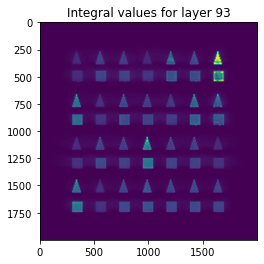

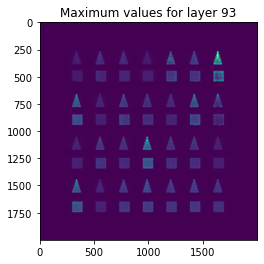

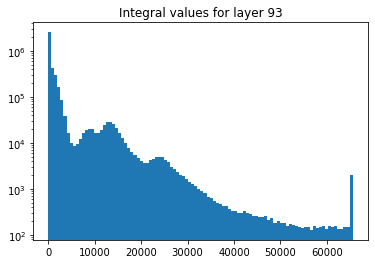

In [4]:
plt.imshow(original[93], vmin=0, vmax=65535)
plt.title("Integral values for layer 93")
plt.figure()
plt.imshow(maxs[93])
plt.title("Maximum values for layer 93")
plt.figure()
plt.title("Integral values for layer 93")
plt.yscale("log")
plt.hist(original[93].flatten(), bins=100)


Let's take a look at the individual items. In the absolute plot, yellow is the highest possible value (65535). In the relative plot, yellow is the highest value found in the image. It is quite a bit easier to see differences inside the colder objects when looking at the relative instead of absolute plot.

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/3297442685.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


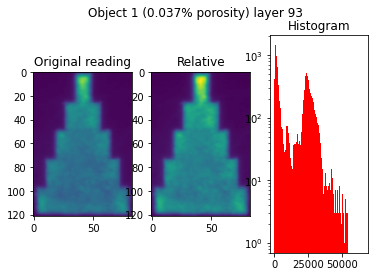

<Figure size 432x288 with 0 Axes>

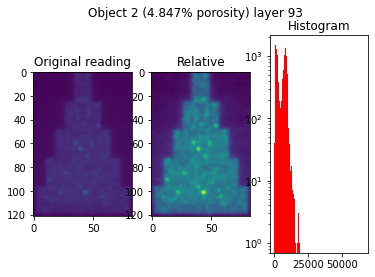

<Figure size 432x288 with 0 Axes>

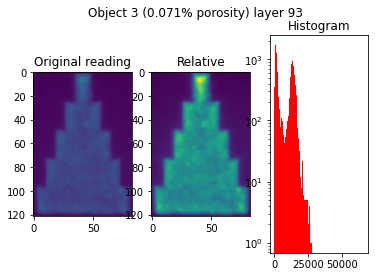

<Figure size 432x288 with 0 Axes>

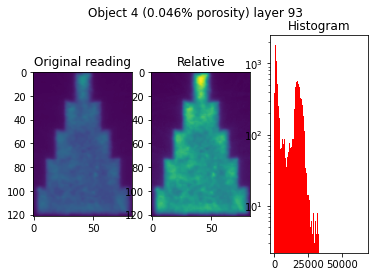

<Figure size 432x288 with 0 Axes>

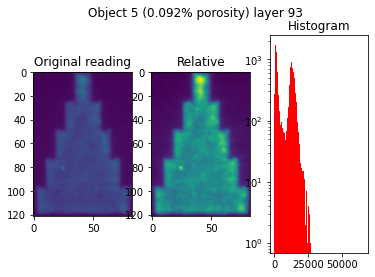

<Figure size 432x288 with 0 Axes>

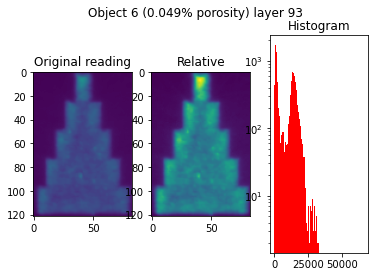

<Figure size 432x288 with 0 Axes>

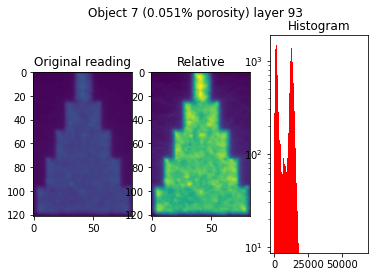

<Figure size 432x288 with 0 Axes>

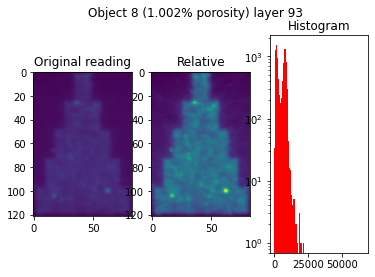

<Figure size 432x288 with 0 Axes>

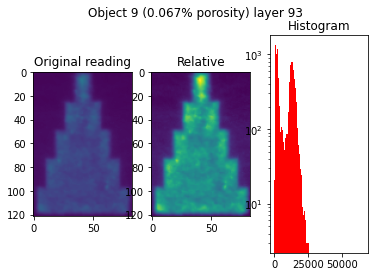

<Figure size 432x288 with 0 Axes>

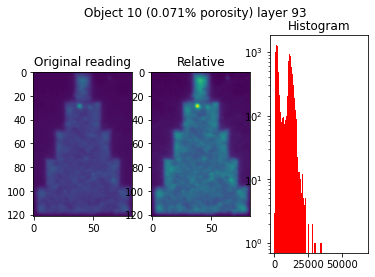

<Figure size 432x288 with 0 Axes>

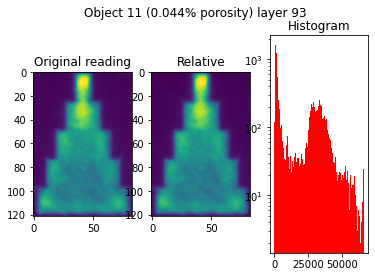

<Figure size 432x288 with 0 Axes>

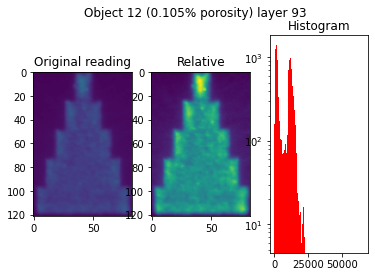

<Figure size 432x288 with 0 Axes>

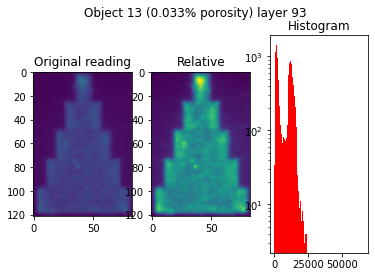

<Figure size 432x288 with 0 Axes>

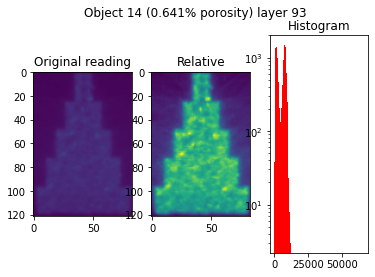

<Figure size 432x288 with 0 Axes>

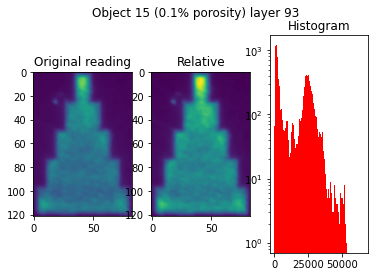

<Figure size 432x288 with 0 Axes>

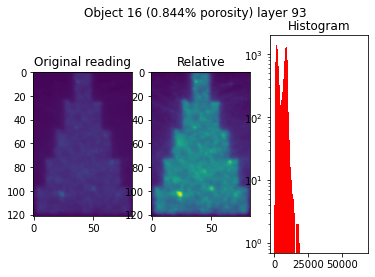

<Figure size 432x288 with 0 Axes>

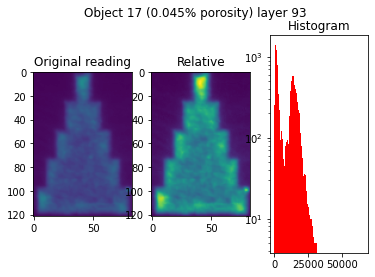

<Figure size 432x288 with 0 Axes>

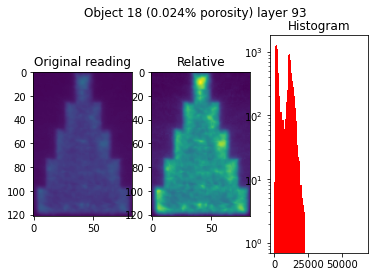

<Figure size 432x288 with 0 Axes>

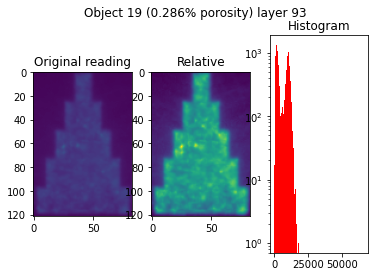

<Figure size 432x288 with 0 Axes>

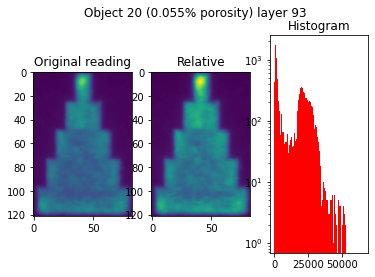

<Figure size 432x288 with 0 Axes>

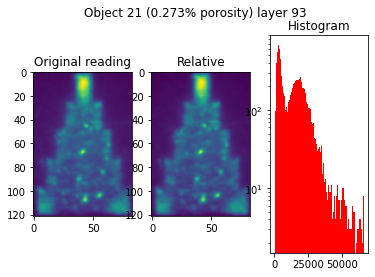

<Figure size 432x288 with 0 Axes>

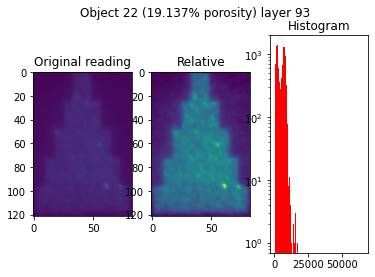

<Figure size 432x288 with 0 Axes>

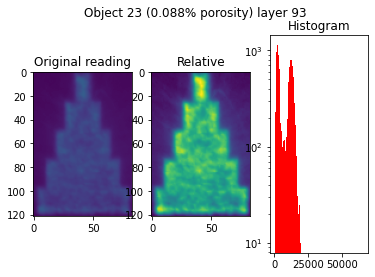

<Figure size 432x288 with 0 Axes>

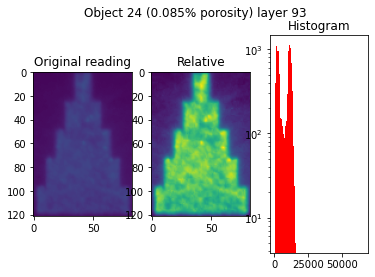

<Figure size 432x288 with 0 Axes>

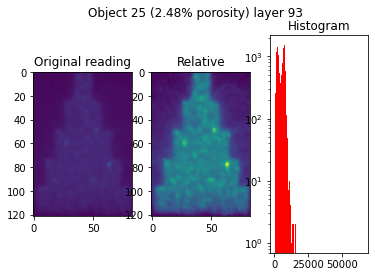

<Figure size 432x288 with 0 Axes>

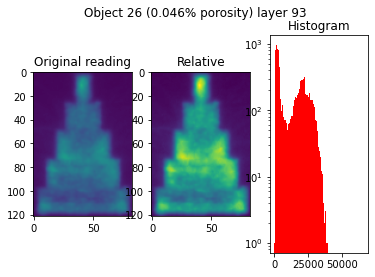

<Figure size 432x288 with 0 Axes>

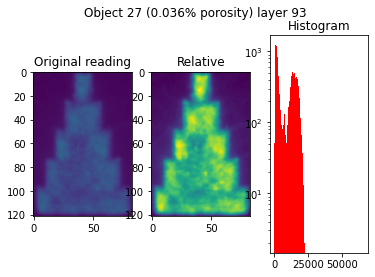

<Figure size 432x288 with 0 Axes>

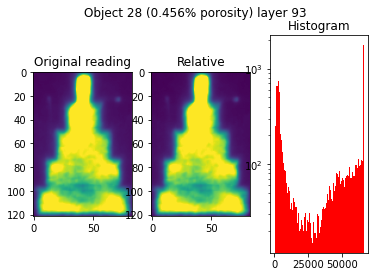

<Figure size 432x288 with 0 Axes>

In [5]:
# These values were extracted manually from the file
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=[
                       'xstart', 'xend', 'ystart', 'yend'])
newdf = coorddf.join(objectinfo)
imageNo = 93
for index, object in newdf.iterrows():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Object " + str(index+1) + " (" + str(object.Porosity) + "% porosity) layer " + str(imageNo))
    ax1.set_title("Original reading")
    ax1.imshow(original[imageNo,object.ystart:object.yend,
               object.xstart:object.xend], vmin=0, vmax=65535)
    ax2.set_title("Relative")
    # ax2.imshow(np.sum(original[90:93, object.ystart:object.yend,
    #            object.xstart:object.xend], axis=0))
    ax2.imshow(original[imageNo, object.ystart:object.yend,object.xstart:object.xend])
    ax3.set_title("Histogram")
    ax3.hist(original[imageNo,object.ystart:object.yend,object.xstart:object.xend].flatten(), bins=100, color='r', range=(0,65535))
    ax3.set_yscale('log')
    plt.figure()


Let's take a look at the maximum images as well

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/1634877868.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


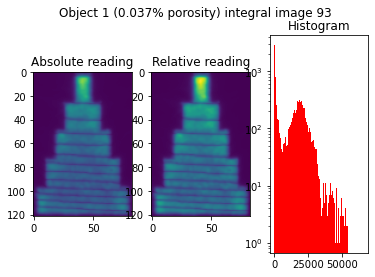

<Figure size 432x288 with 0 Axes>

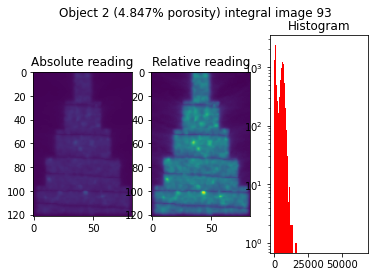

<Figure size 432x288 with 0 Axes>

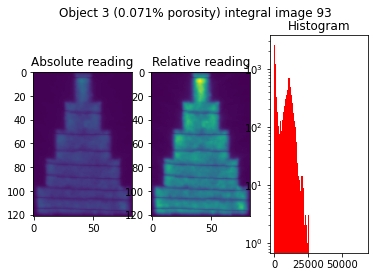

<Figure size 432x288 with 0 Axes>

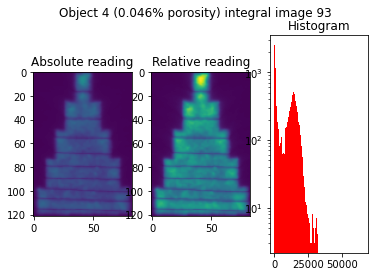

<Figure size 432x288 with 0 Axes>

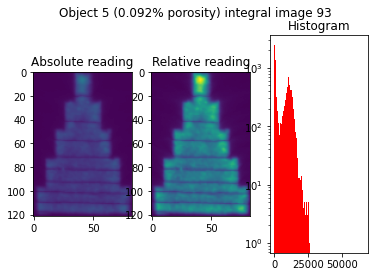

<Figure size 432x288 with 0 Axes>

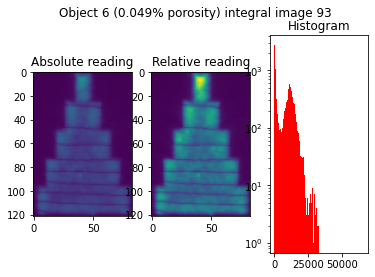

<Figure size 432x288 with 0 Axes>

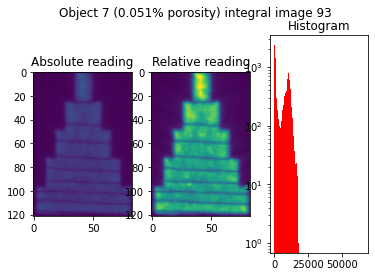

<Figure size 432x288 with 0 Axes>

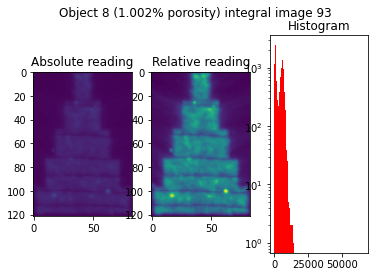

<Figure size 432x288 with 0 Axes>

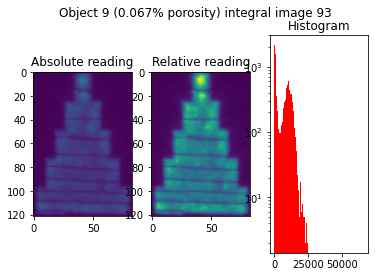

<Figure size 432x288 with 0 Axes>

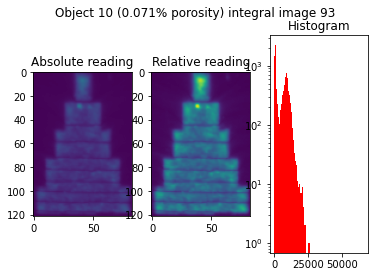

<Figure size 432x288 with 0 Axes>

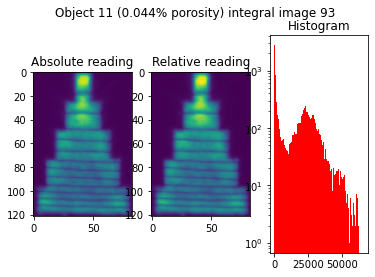

<Figure size 432x288 with 0 Axes>

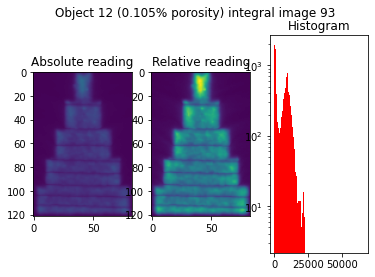

<Figure size 432x288 with 0 Axes>

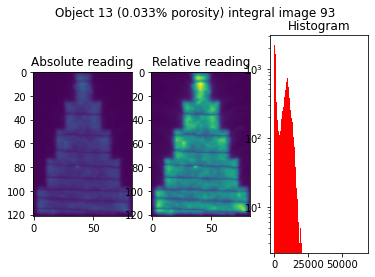

<Figure size 432x288 with 0 Axes>

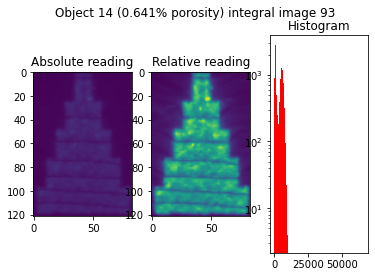

<Figure size 432x288 with 0 Axes>

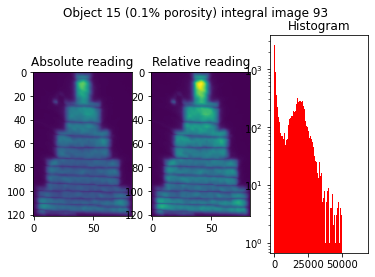

<Figure size 432x288 with 0 Axes>

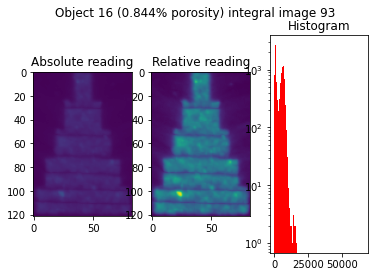

<Figure size 432x288 with 0 Axes>

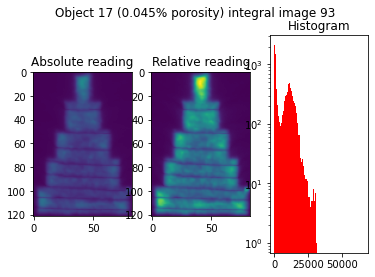

<Figure size 432x288 with 0 Axes>

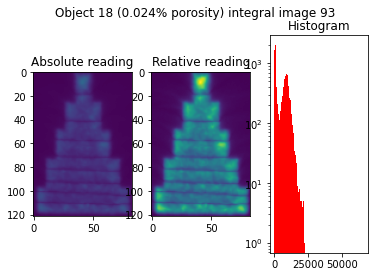

<Figure size 432x288 with 0 Axes>

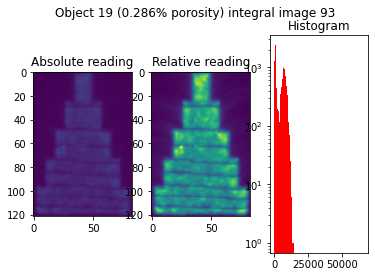

<Figure size 432x288 with 0 Axes>

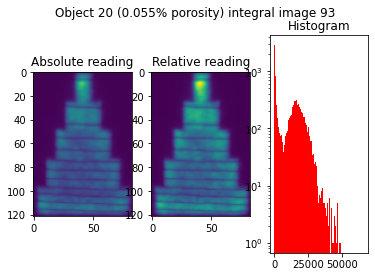

<Figure size 432x288 with 0 Axes>

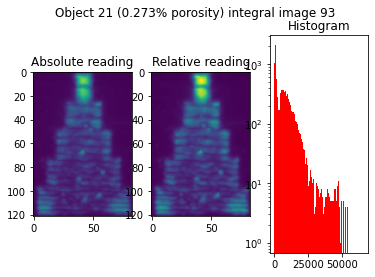

<Figure size 432x288 with 0 Axes>

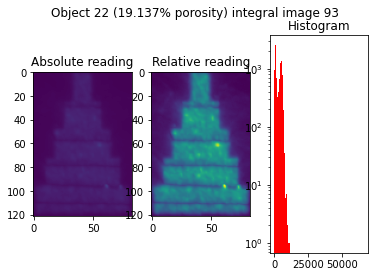

<Figure size 432x288 with 0 Axes>

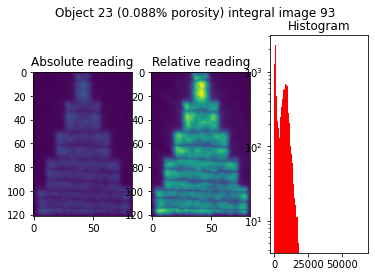

<Figure size 432x288 with 0 Axes>

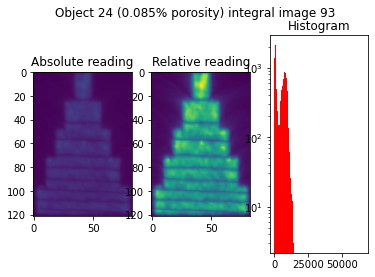

<Figure size 432x288 with 0 Axes>

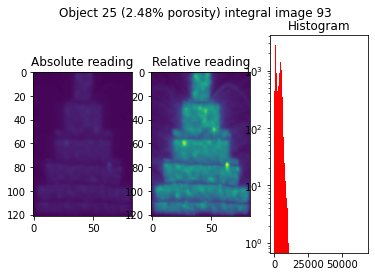

<Figure size 432x288 with 0 Axes>

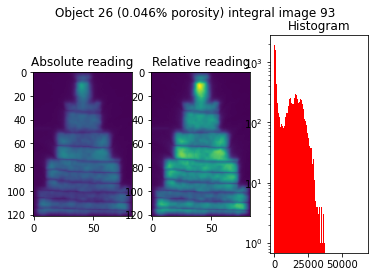

<Figure size 432x288 with 0 Axes>

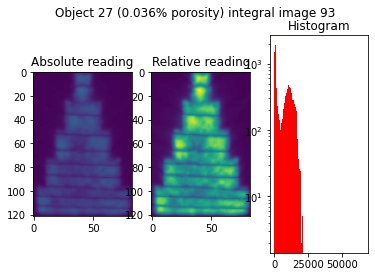

<Figure size 432x288 with 0 Axes>

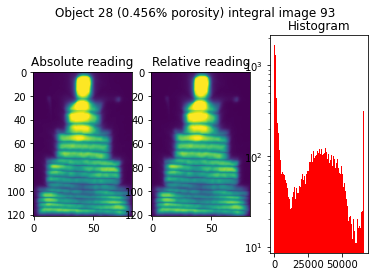

<Figure size 432x288 with 0 Axes>

In [6]:
imageNo = 93
for index, object in newdf.iterrows():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Object " + str(index+1) + " (" + str(object.Porosity) +
                 "% porosity) integral image " + str(imageNo))
    ax1.set_title("Absolute reading")
    ax1.imshow(maxs[imageNo][object.ystart:object.yend,
               object.xstart:object.xend], vmin=0, vmax=65535)
    ax2.set_title("Relative reading")
    ax2.imshow(maxs[imageNo][object.ystart:object.yend,
               object.xstart:object.xend])
    ax3.set_title("Histogram")
    ax3.hist(maxs[imageNo, object.ystart:object.yend, object.xstart:object.xend].flatten(
    ), bins=100, color='r', range=(0, 65535))
    ax3.set_yscale('log')
    plt.figure()

Finally, let's compare the two images (integral and maximum). There appears to be no clear pattern. Ask Zhouer about the lines, investigate what may cause them.

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/1495445975.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


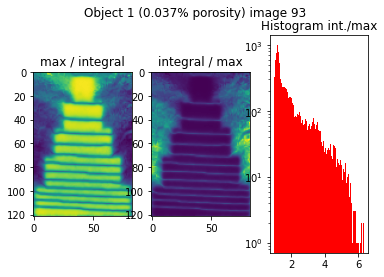

<Figure size 432x288 with 0 Axes>

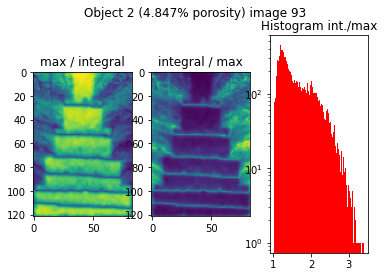

<Figure size 432x288 with 0 Axes>

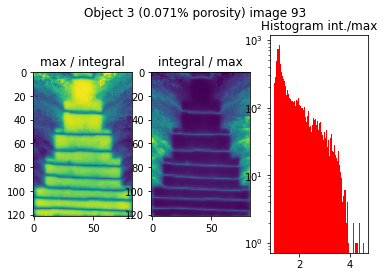

<Figure size 432x288 with 0 Axes>

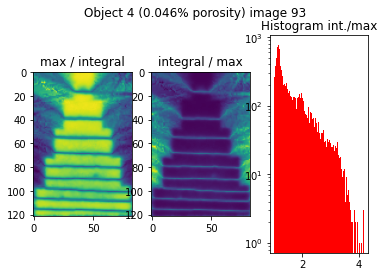

<Figure size 432x288 with 0 Axes>

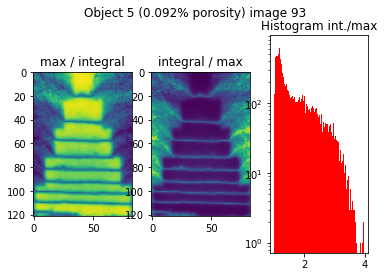

<Figure size 432x288 with 0 Axes>

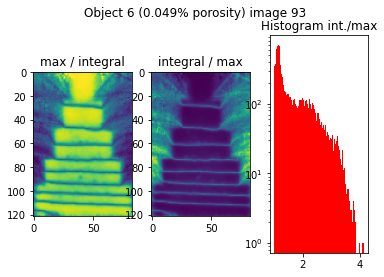

<Figure size 432x288 with 0 Axes>

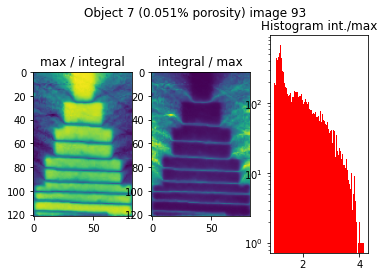

<Figure size 432x288 with 0 Axes>

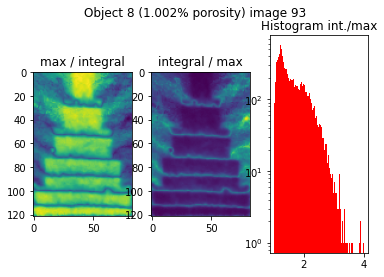

<Figure size 432x288 with 0 Axes>

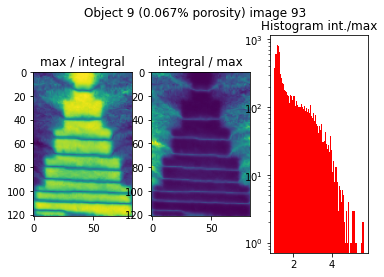

<Figure size 432x288 with 0 Axes>

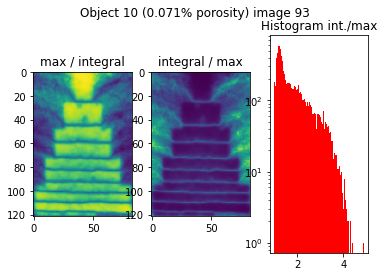

<Figure size 432x288 with 0 Axes>

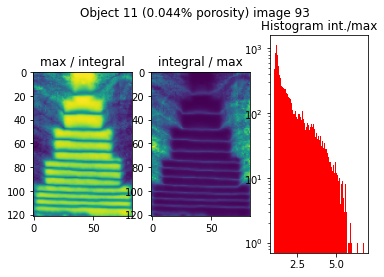

<Figure size 432x288 with 0 Axes>

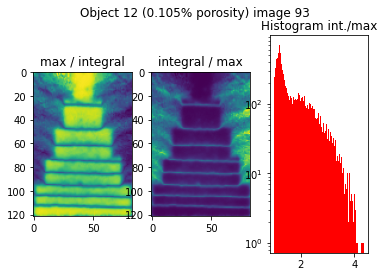

<Figure size 432x288 with 0 Axes>

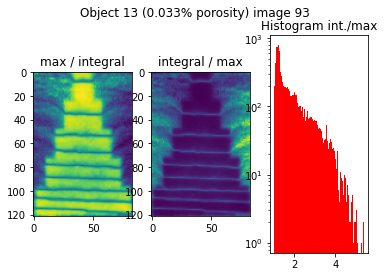

<Figure size 432x288 with 0 Axes>

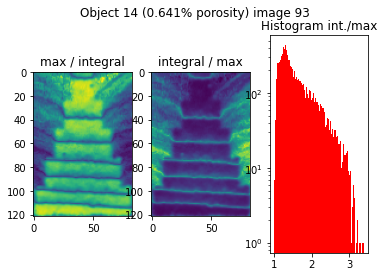

<Figure size 432x288 with 0 Axes>

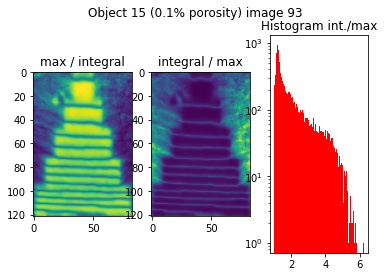

<Figure size 432x288 with 0 Axes>

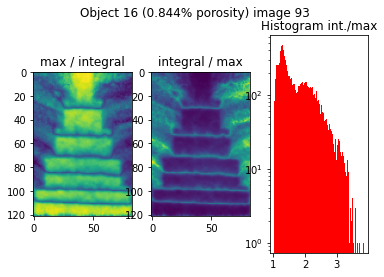

<Figure size 432x288 with 0 Axes>

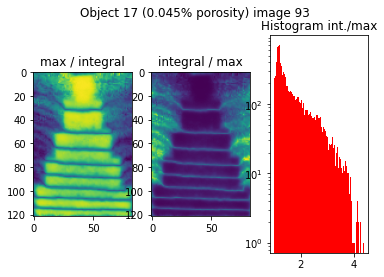

<Figure size 432x288 with 0 Axes>

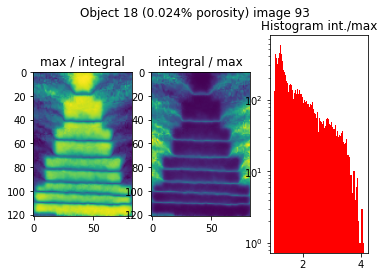

<Figure size 432x288 with 0 Axes>

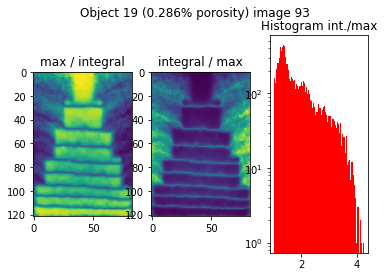

<Figure size 432x288 with 0 Axes>

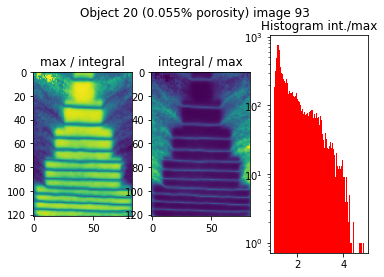

<Figure size 432x288 with 0 Axes>

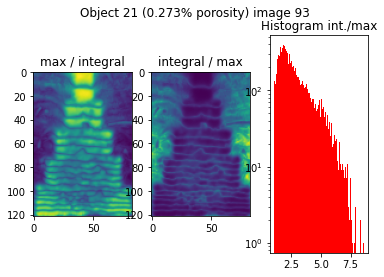

<Figure size 432x288 with 0 Axes>

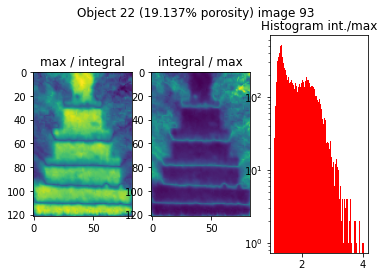

<Figure size 432x288 with 0 Axes>

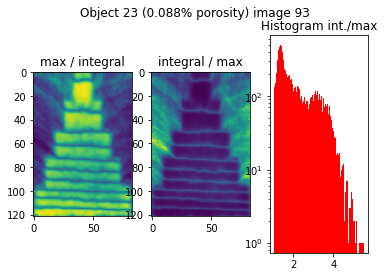

<Figure size 432x288 with 0 Axes>

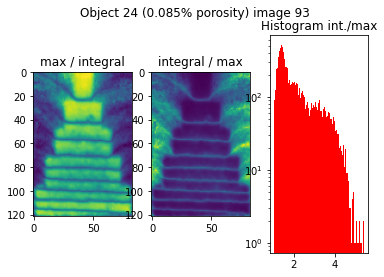

<Figure size 432x288 with 0 Axes>

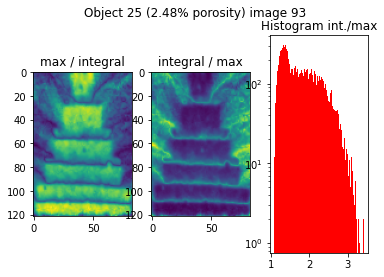

<Figure size 432x288 with 0 Axes>

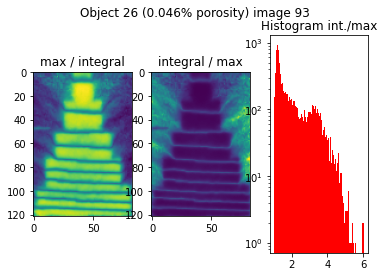

<Figure size 432x288 with 0 Axes>

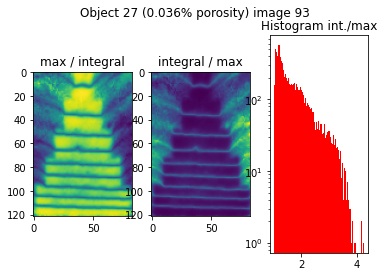

<Figure size 432x288 with 0 Axes>

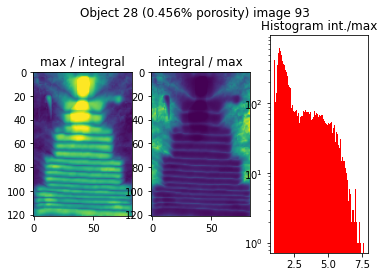

<Figure size 432x288 with 0 Axes>

In [7]:
imageNo = 93
for index, object in newdf.iterrows():
    diff = maxs[imageNo][object.ystart:object.yend,object.xstart:object.xend] / original[imageNo][object.ystart:object.yend,object.xstart:object.xend]
    diffrev = original[imageNo][object.ystart:object.yend, object.xstart:object.xend] / \
        maxs[imageNo][object.ystart:object.yend, object.xstart:object.xend]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Object " + str(index+1) + " (" + str(object.Porosity) +
                 "% porosity) image " + str(imageNo))
    ax1.set_title("max / integral")
    ax1.imshow(diff)
    ax2.set_title("integral / max")
    ax2.imshow(diffrev)
    ax3.set_title("Histogram int./max")
    ax3.hist(diffrev.flatten(
    ), bins=100, color='r')
    ax3.set_yscale('log')
    plt.figure()


Now that we can fetch the OT readings for each object, let's sum the OT readings for each object

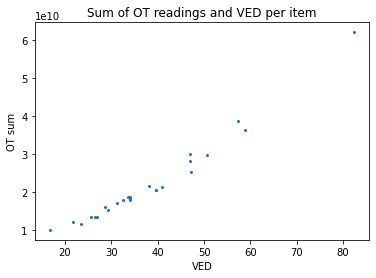

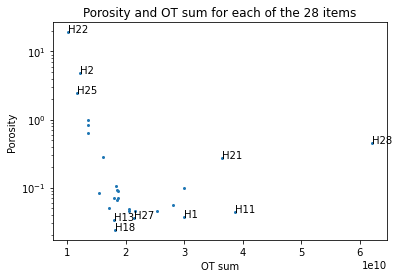

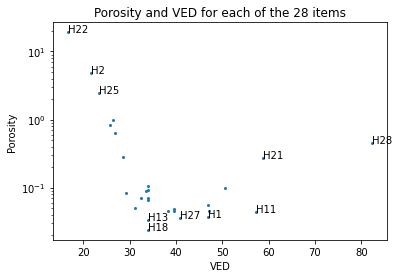

In [8]:
sums = [np.sum(original[:,object.ystart:object.yend,object.xstart:object.xend]) for index, object in coorddf.iterrows()]
plt.scatter(objectinfo.filter(items=['VED']),
            sums, s=4)
plt.ylabel("OT sum")
plt.xlabel("VED")
plt.title("Sum of OT readings and VED per item")
plt.figure()

plt.scatter(sums,
            objectinfo.filter(items=['Porosity']), s=4)
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("OT sum")
plt.title("Porosity and OT sum for each of the 28 items")
ii = [0, 1, 10, 12, 17, 20, 21, 24, 26, 27]
for index, row in objectinfo.iloc[ii].iterrows():
    plt.annotate(text=row.Object, xy=(sums[index], row.Porosity))
plt.figure()

plt.scatter(objectinfo.filter(items=['VED']),
            objectinfo.filter(items=['Porosity']), s=4)
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("VED")
plt.title("Porosity and VED for each of the 28 items")
for index, row in objectinfo.iloc[ii].iterrows():
    plt.annotate(text=row.Object, xy=(row.VED, row.Porosity))

Let's take a look at the distribution of OT readings. As can be seen in the histograms, there are a lot of 0 values (which is expected), but also a lot of values that are close to 0.

Another interesting aspect is that there is a peak in the maximum value.

Note that the y axis is logarithmic.

<Figure size 432x288 with 0 Axes>

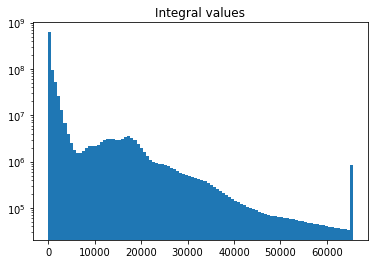

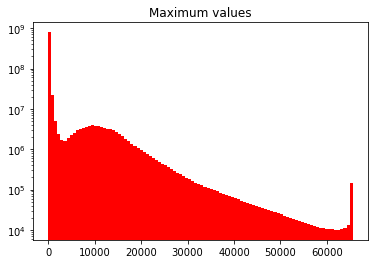

<Figure size 432x288 with 0 Axes>

In [9]:
plt.title('Integral values')
plt.hist(ims.flatten(), bins=100)
plt.yscale('log')
plt.figure()
plt.title('Maximum values')
plt.hist(maxs.flatten(), bins=100, color='r')
plt.yscale('log')
plt.figure()
# plt.title('Integral values')
# plt.hist(ims.flatten(), bins=100, range=(3000, 65537))
# plt.figure()
# plt.title('Maximum values')
# plt.hist(maxs.flatten(), bins=100, range=(3000, 65537), color='r')


Let's highlight all areas with non-zero values from one of the images

Text(0.5, 1.0, 'Maximum values >0 of image 93')

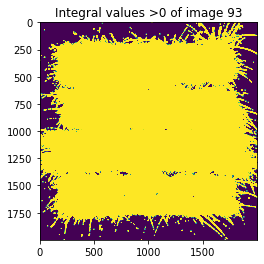

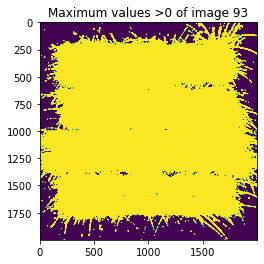

In [10]:
plt.imshow(original[93], vmax=1)
plt.title("Integral values >0 of image 93")
plt.figure()
plt.imshow(maxs[93], vmax=1)
plt.title("Maximum values >0 of image 93")


Question for Zhouer: it looks like spatter. Is that correct?

We can see there is valley at around 5800 for integral values and 3300 for maximum values in the histograms. Let's see those areas:

Text(0.5, 1.0, 'Maximum values >3300 of image 93')

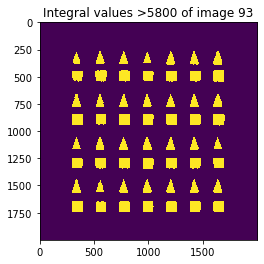

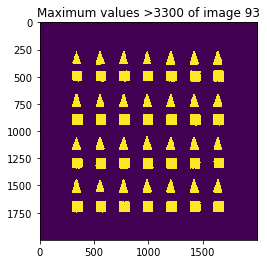

In [11]:
plt.imshow(original[93], vmin=5800, vmax=5801)
plt.title("Integral values >5800 of image 93")
plt.figure()
plt.imshow(maxs[93], vmin=3300, vmax=3301)
plt.title("Maximum values >3300 of image 93")


Let's compare integral and maximum values. Since higher porosity should result in lower thermal conductivity, we may be able to see some patterns.

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/627761642.py:9: RuntimeWarning: divide by zero encountered in true_divide
  diff = im / maxi
/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/627761642.py:9: RuntimeWarning: invalid value encountered in true_divide
  diff = im / maxi


Text(0.5, 1.0, 'Ratio between integral and maximum value, image 93')

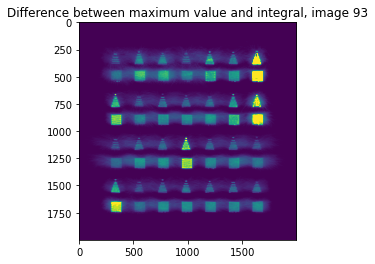

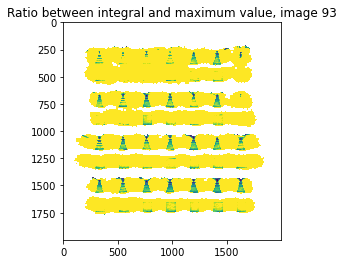

In [12]:
im = np.copy(original)
maxi = np.copy(maxs)
diff = im[93] - maxi[93]
plt.imshow(diff, vmax=10000)
plt.title("Difference between maximum value and integral, image 93")
plt.figure()
im = np.copy(original[93])
maxi = np.copy(maxs[93])
diff = im / maxi
plt.imshow(diff, vmax=1.5)
plt.title("Ratio between integral and maximum value, image 93")


The second image, the one displaying the ratio, has some issues. First, the white areas are areas where the maximum reading was 0 (resulting in a division by 0 error). Second, the area surrounding the build objects have the highest ratio when comparing the integral with the maximum value. Let's try to filter the build objects to see them more clearly.

/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/4270924258.py:4: RuntimeWarning: divide by zero encountered in true_divide
  diff = im / maxi
/var/folders/q8/tcfvx04d1y11jv7mj6t996fr0000gn/T/ipykernel_42915/4270924258.py:4: RuntimeWarning: invalid value encountered in true_divide
  diff = im / maxi


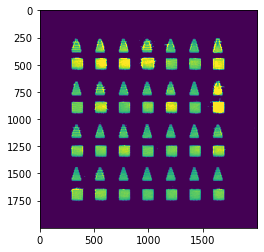

In [13]:
im = np.copy(original[93])
maxi = np.copy(maxs[93])
# maxi = np.where(maxi == 0, 1, maxi)
diff = im / maxi
plt.imshow(np.where(maxi < 1000, 0, diff), vmax=2)

# Interesting that it doesn't appear to affect thermal conductivity...
# Would be interesting to plot average and max OT reading and porosity vs energy input

Let's try some clustering. 

In [14]:
# The clustering block
# Let's do idk, single linkage?
# Can we piggyback off of scikit learn?
# Solving the 2d problem is easy (there's solutions in place). How do we do it
# for the time dimension? One option would be to layer multiple timestamps on top of each other (sliding window)
# How do we know if the clustering makes sense? We don't, yet. We need to integrate pore data for that.
# For now, construct a naive single linkage?
# Some thoughts: a spatial cluster may suggest pore formation. A temporal cluster may suggest pore not being fixed. If we just merge all the points, 
# we lose information about the temporal relationship between them.
# About representation. We can either transform the matrix into a sparse matrix (encoding higher than threshold as 1, lower than as 0), or we can 
# represent it as a matrix of x, y values.
# Regardless, it would be cool to have something today or tomorrow to show...
# Initial approach: DBSCAN with tweaked parameters. Use out-of-the-box algorithm from scikit.
# Todo later: write code to map the pore data into a 2000x2000 matrix describing the porosity of that cell.
# Todo: Ask Zhouer about the camera. Would be great to know the resolution since there's this blur at the edge making it hard to see where the object truly ends.
# Todo: Ask Zhouer about

# Approach 1: sliding window and dbscan
pictures = np.copy(original)
start_layer = 87
end_layer = 99
layersOfInterest = pictures[start_layer:end_layer]
points = np.array([[t, x, y, value] for (t, x, y), value in np.ndenumerate(layersOfInterest)])
# for threshold in thresholds:
#     for (t, x, y), value in np.ndenumerate(pictures):
#         if(value > threshold):
#             points.append([t, threshold, x, y])
# May need to speed this up a bit. How about we first 
# [ enumerate(picture) for threshold in thresholds]
df = pd.DataFrame(points, columns=['layer', 'x', 'y', 'value'])


In [ ]:
# # Temp block, cut later
# # What I wanna know is, why don't the pixels show up?
# df[df.value > 32766]
# # When converting to df(or  array), we make values 
# wat = pictures[start_layer:end_layer].flatten()
# np.unique(wat)



KeyboardInterrupt: 

In [ ]:
np.unique(p2[:,3])

array([    0,     1,     2, ..., 65533, 65534, 65535])

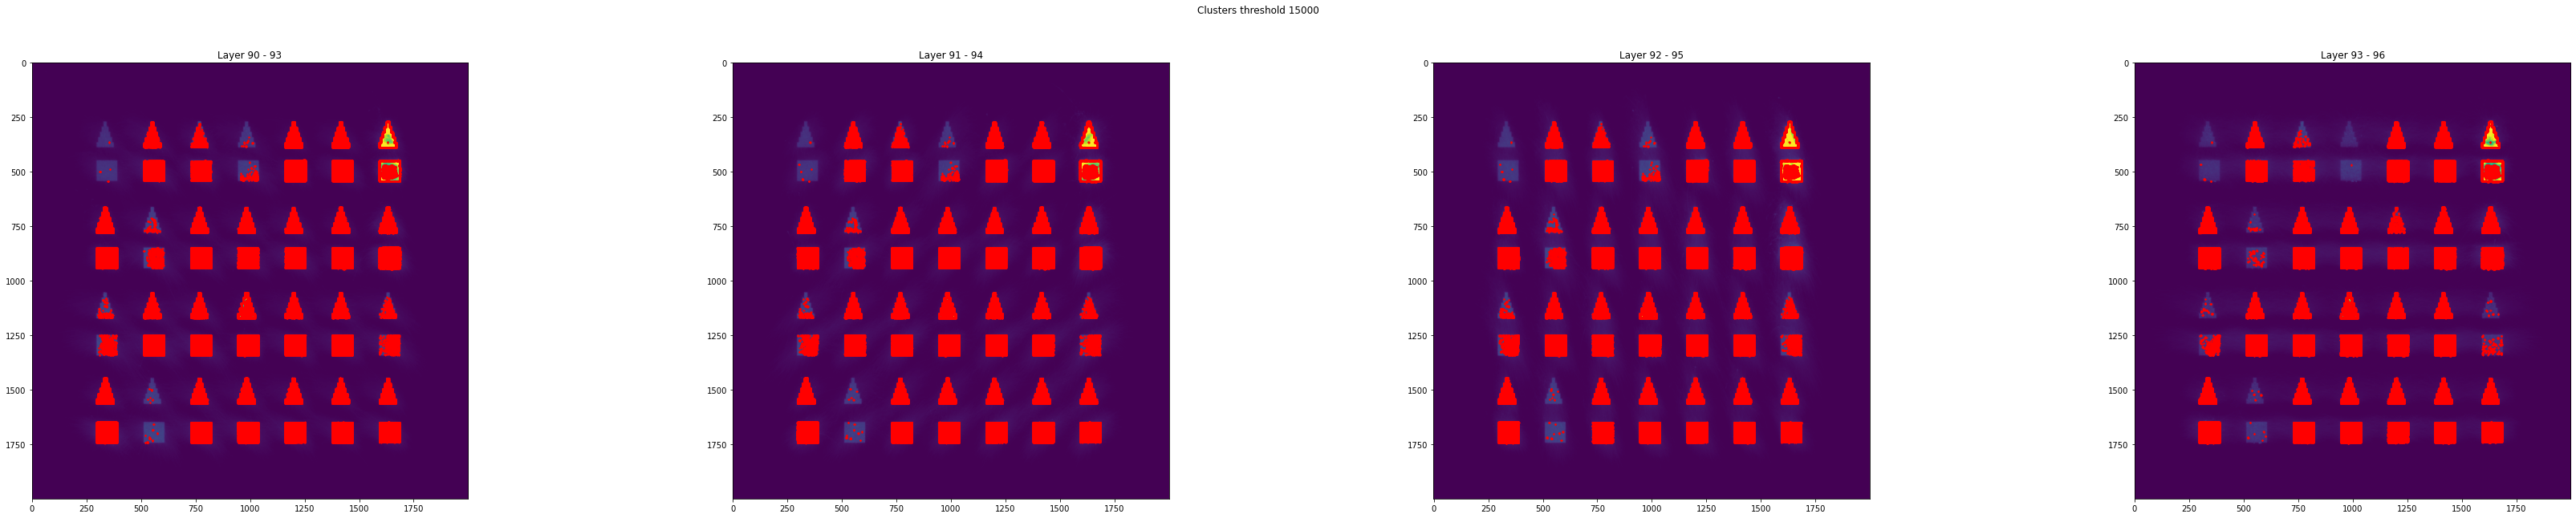

<Figure size 432x288 with 0 Axes>

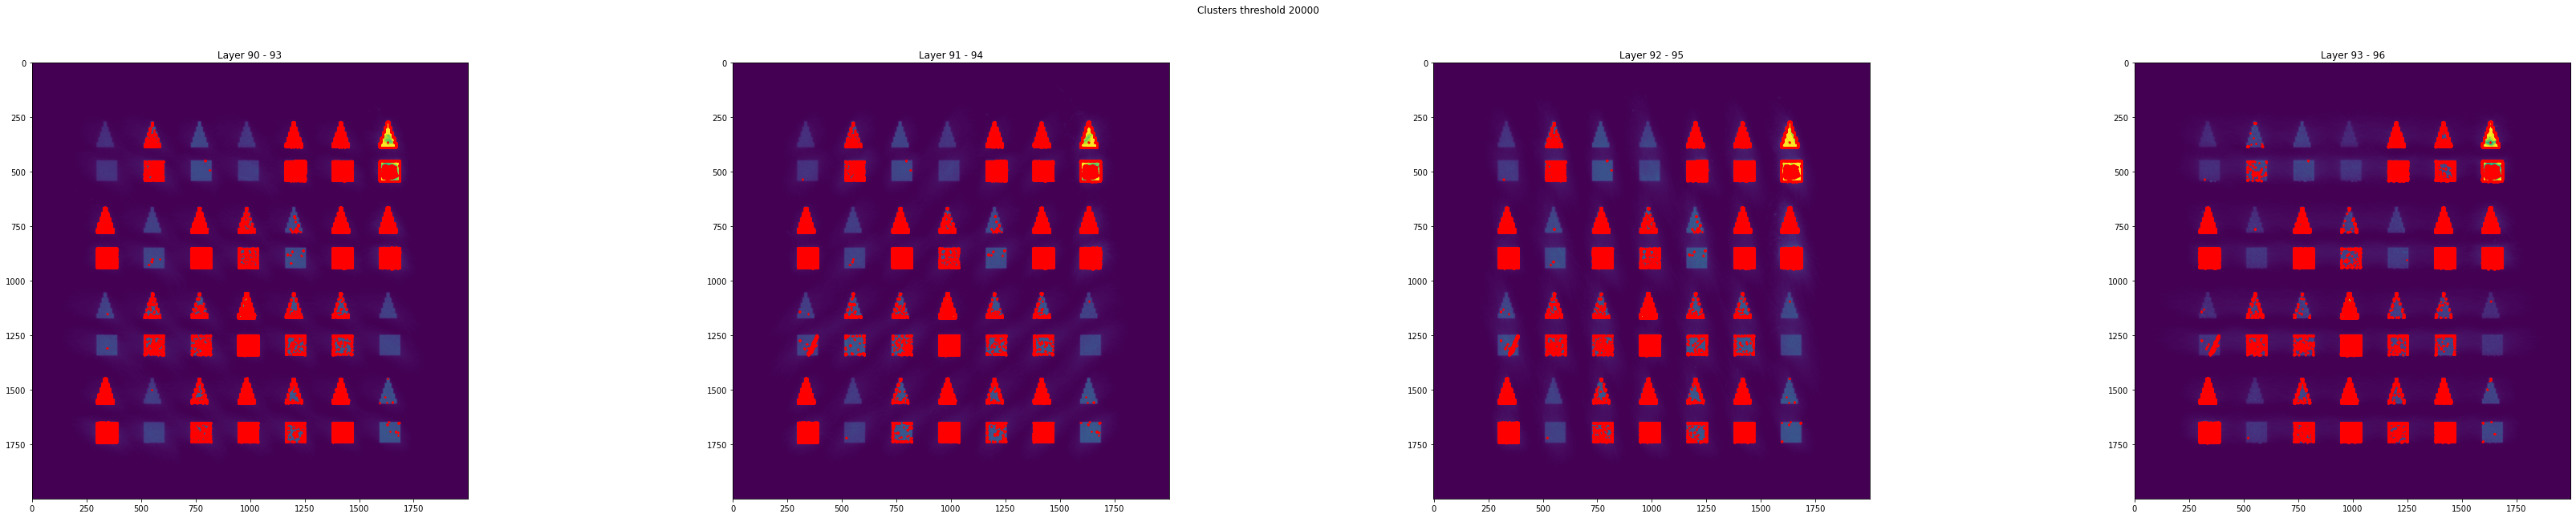

<Figure size 432x288 with 0 Axes>

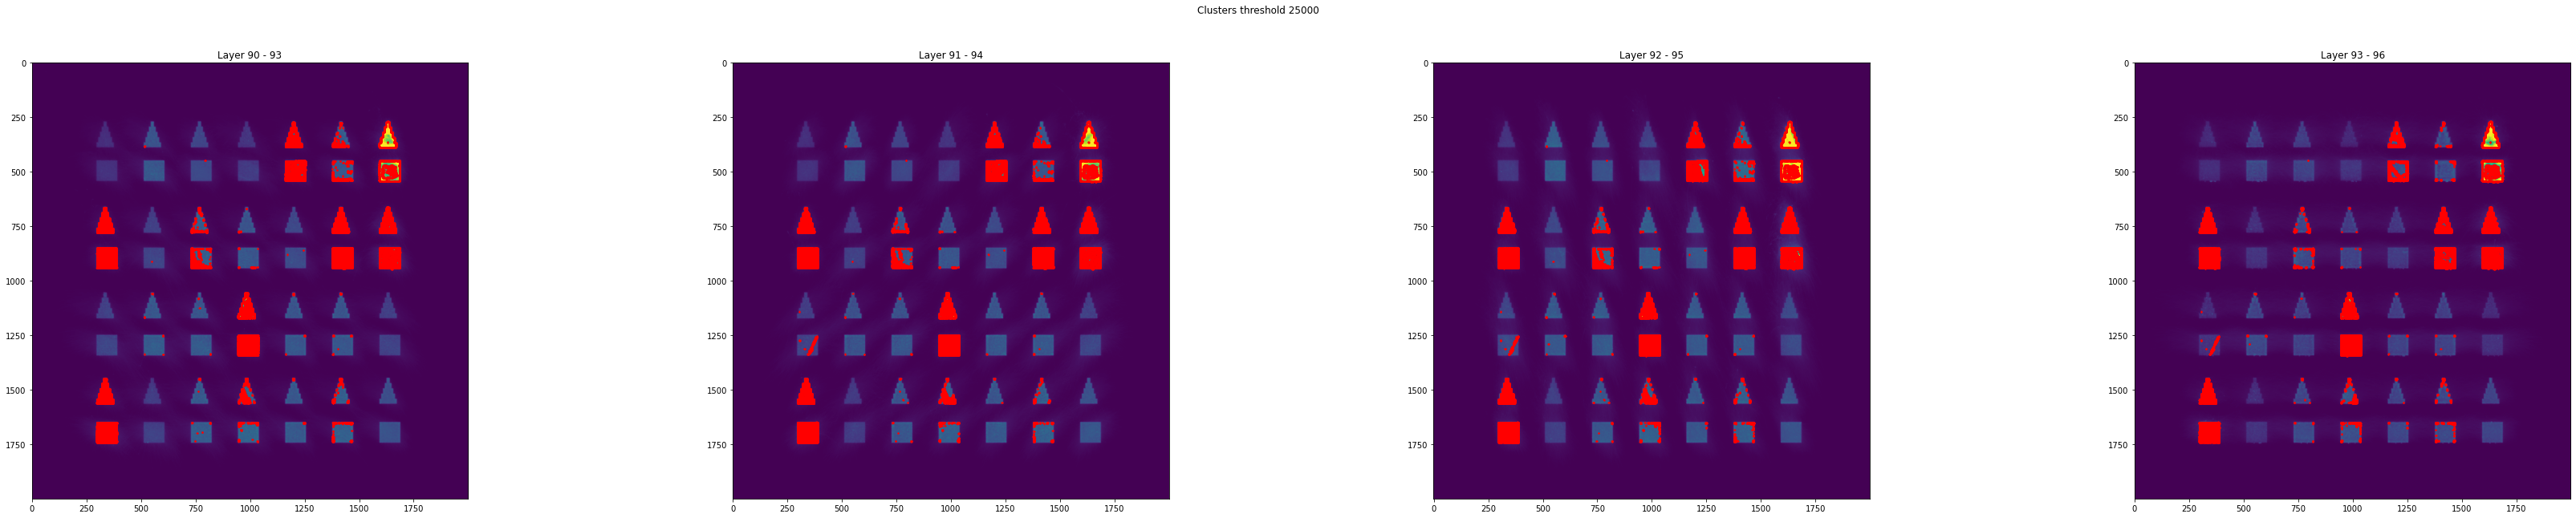

<Figure size 432x288 with 0 Axes>

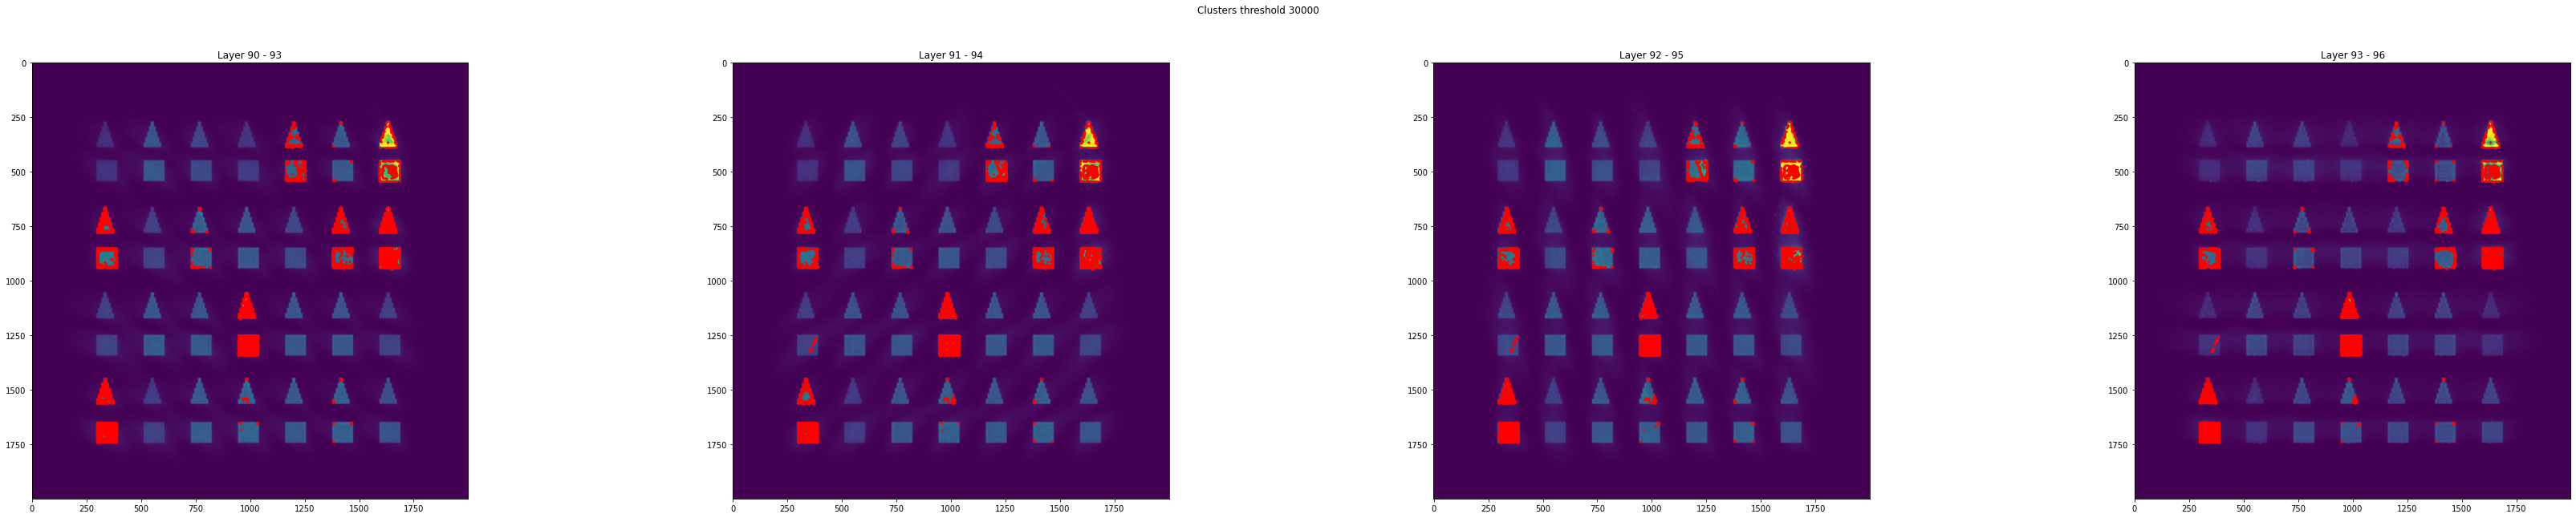

<Figure size 432x288 with 0 Axes>

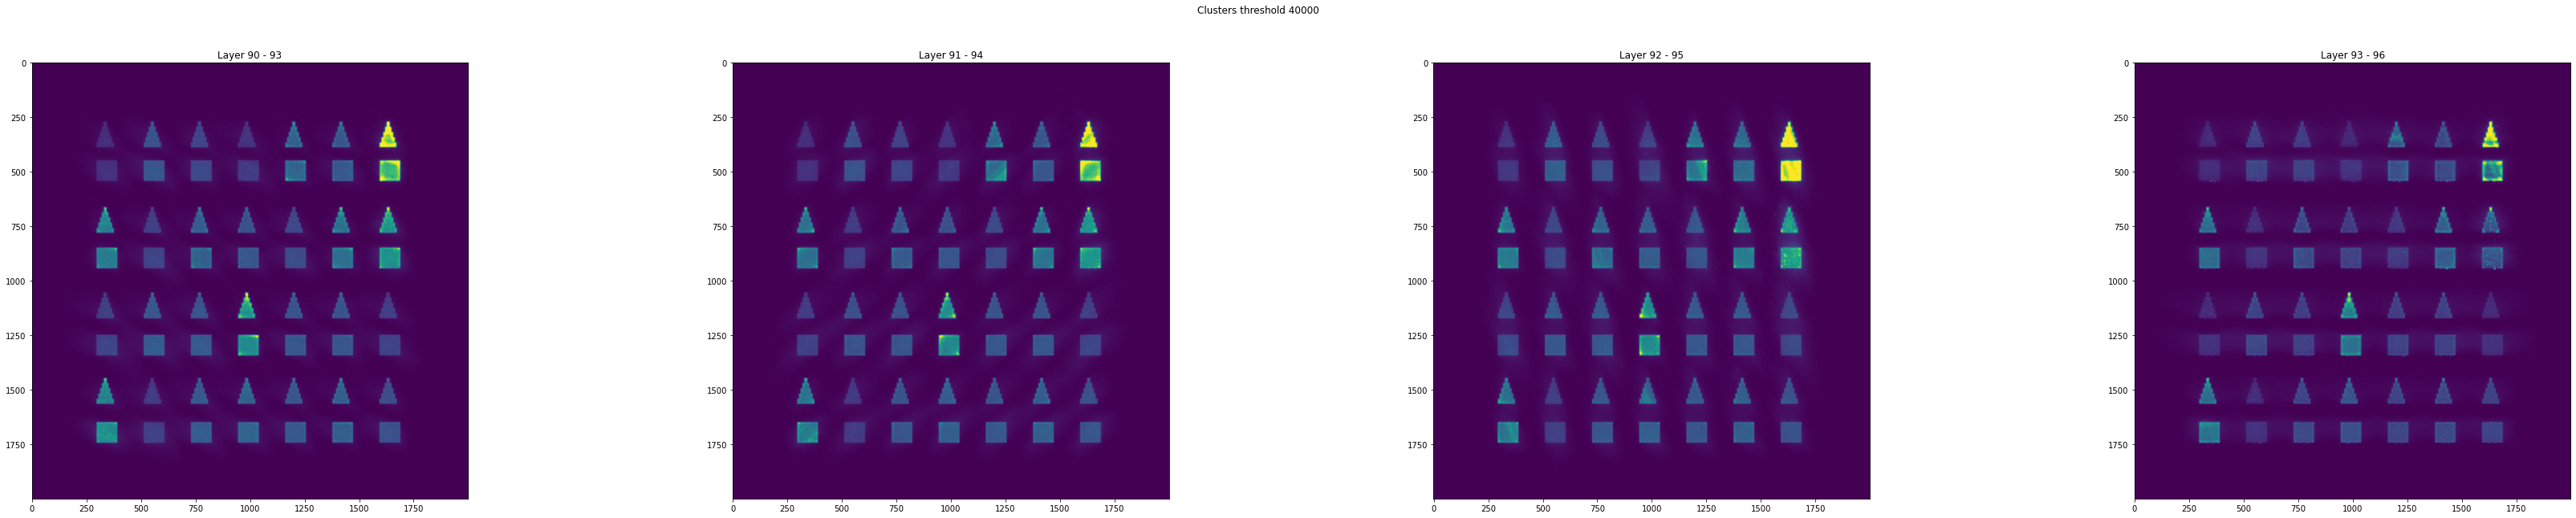

<Figure size 432x288 with 0 Axes>

In [ ]:
# The time complexity here is disgusting
# How about we do window size 4, print all?
window_size = 4
thresholds = [15000, 20000, 25000, 30000, 40000]
eps = 1.5
minpts = 3
clusterings = pd.DataFrame(columns=['StartLayer', 'x', 'y', 'Cluster'])
dbscan = cluster.DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
results = []
# Pseudocode
# For each threshold, conduct dbscan. Plot the clusters identified on the image. Ignore the noise.
# Start with a single threshold
for threshold in thresholds:
    for i in range(0, end_layer - start_layer - window_size + 1):
        filterArray = (df.layer >= i) & (df.layer < i+window_size) & (df.value > threshold)
        dataToCluster = df[filterArray].filter(items=['x', 'y'])
        if len(dataToCluster.index) == 0:
            continue
        result = dbscan.fit_predict(dataToCluster)
        dataToCluster.insert(loc=0, column="Cluster", value=result)
        dataToCluster.insert(loc=0, column="StartLayer", value=i + start_layer)
        dataToCluster.insert(loc=0, column="Threshold", value=threshold)
        results.append(dataToCluster)
clusterings = pd.concat(results)
for threshold in thresholds:
    noOfPlots = window_size
    fig, axs = plt.subplots(1, noOfPlots, figsize=(60, 10))
    fig.suptitle("Clusters threshold " + str(threshold))
    for index, ax in enumerate(axs):
        currentStartLayer = (start_layer + end_layer) // 2 - window_size + index + 1
        ax.set_title("Layer " + str(currentStartLayer) +
                     " - " + str(currentStartLayer + window_size - 1))
        pointsToShow = clusterings[(clusterings.StartLayer == currentStartLayer) & (
            clusterings.Cluster != -1) & (clusterings.Threshold == threshold)]
        ax.scatter(pointsToShow.filter(items=['y']), pointsToShow.filter(
            items=['x']), s=1, c='r')
        ax.imshow(pictures[currentStartLayer])
    plt.figure()
# How do we show the result?
# Print them on a canvas?

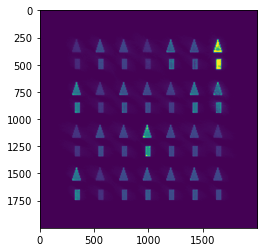

In [ ]:
# Roughly speaking, how's the resolution here compared to the pore data?
# 75 x 117 vs 11100 x 16700
# Roughly 9000 vs 185'370'000
# Pores under 148px wide may go unnoticed. We don't have the resolution for individual pore detection.
# Maybe we can instead look at grids and measure porosity in those grids?
# What's a "good" reading?
# Picture 93 is at 7520, i.e. right after the cross-section. Assuming we have up to five layers of melting,
# it may be interesting to consider from layer 88 until 98.
# How do we set good thresholds? 
# Idea 1: look at the value compared across the whole picture
# Idea 2: look at the value compared to the rest of the build item
# Would be interesting to compare the two approaches to see if either can be used to identify pores.
# Would be interesting to know which ones have the lowest and highest porosity. There's two opposing forces here:
# high energy results in warmer objects (more reading)
# low energy results in large pores (more reading)
# NOTE: Bottom left build item is object 1. Top right is object 28.
# Interesting, the heat is A LOT higher in the first layer. Guess the conductivity of the build plate plays a role.
# It would be interesting to plot:
# porosity vs energy (done)
# OT vs energy
# porosity vs OT (hypothesis: low and high result in higher porosity. If it doesn't we're possibly fucked)